In [13]:
library (tidyverse)
library (ggraph)
library (tidygraph)
library (igraph)
library (ggforce)
library (oaqc)
library (graphlayouts)
library(dplyr)
library(pheatmap)
library(goeveg)
Morphogen_full <-  c(
  Ctrl = "#000000",
  SHH_A = "#FFC370",
  SHH_E = "#FF990A",
  RA_A = "#E0EB47",
  RA_E = "#9BA512",
  CHIR_A = "#B0D4D4",
  CHIR_E = "#569F9E",
  FGF8_late_A = "#C7AED6",
  FGF8_late_E = "#8452A3"
)

cols_Cell_Line <- c(
  WTC = "#2088C9",
  H9 = "#FFC502",
  WIBJ2 = "#332288",
  H1 = "#44AA99"
)

save_pheatmap_pdf <- function(x, filename, width=7, height=7) {
    stopifnot(!missing(x))
    stopifnot(!missing(filename))
    pdf(filename, width=width, height=height)
grid::grid.newpage()
grid::grid.draw(x$gtable)
    dev.off()
}

path_data = ''

## NIM

In [170]:
net1 <- read_tsv (paste0(path_data, "consensus_summary_v2.tsv"))
net1$gene_name <- sapply(strsplit(net1$gene, "--"), function(x) gsub("\\(.*\\)", "", x[2]))
keep = c('CHIR:NIM', 'CHIR:NIM:timing_no', 'FGF8:NIM', 'RA:NIM', 'SHH:NIM')
library(stringr)


net_comb <- net1[(net1$morph %in% keep), ]
net_comb$morph <- str_replace(net_comb$morph, ":timing_no", "")


net_comb<-net_comb%>% 
  select (morph, gene_name, og_morph, w_H1,	corr_H1,	w_H9,	corr_H9,	w_WIBJ2,	corr_WIBJ2,	w_WTC,	corr_WTC	 )

net_comb<-net_comb[!duplicated(net_comb[c('gene_name','morph')]),]

morph_gene_mtx <- table (net_comb$gene_name, net_comb$morph)
morph_label <- apply(morph_gene_mtx, 1, function(x) paste(colnames(morph_gene_mtx)[which(x>0)], collapse = '_'))

# Add the vector with all morphogens (all_morph) assignments to the initial dataframe
net_comb <- net_comb %>%
  mutate (all_morph = morph_label[as.character(gene_name)])


reg_summary <- read_tsv(paste0(path_data, "regulon_summary_sc.tsv"))
reg_size = as.data.frame(table(reg_summary$TF))
colnames(reg_size) <- c('gene_name', 'regulon_size')                    
net_comb_filt <- left_join(net_comb, reg_size,by =  'gene_name') 
dim(net_comb_filt)

table(net_comb_filt$morph)

Rows: 1471 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): og_morph, gene, link, morph
dbl (9): ...1, w_H1, w_H9, w_WIBJ2, w_WTC, corr_H1, corr_WIBJ2, corr_H9, cor...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 81490 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): TF, gene
dbl (5): ...1, WTC, H9, WIBJ2, H1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 94 13


CHIR:NIM FGF8:NIM   RA:NIM  SHH:NIM 
      19        9       31       35 

In [171]:
lookup_morph <- net_comb_filt %>% 
  dplyr::select (morph) %>%
  dplyr::distinct () %>% 

  dplyr::rename (node = morph)


lookup_gene <- net_comb_filt %>%
  dplyr::select (gene_name, regulon_size) %>%
  dplyr::distinct () %>% 
  dplyr::rename (node = gene_name) # Rename to match the name in the graph_tbl object

# Taking the morphogens and adding a column for NULL top_cluster assignments
lookup_morph <- net_comb_filt %>% 
  dplyr::select (morph) %>%
  dplyr::distinct () %>% 
  dplyr::mutate (regulon_size = "NA") %>% 
  dplyr::rename (node = morph) # Rename to match the name in the graph_tbl object

# rbinding the two dataframes
lookup_regulon_size <- rbind (lookup_morph, lookup_gene)
lookup_regulon_size$regulon_size <- as.numeric (lookup_regulon_size$regulon_size)


lookup_gene <- net_comb_filt %>%
  dplyr::select (gene_name, all_morph) %>%
  dplyr::distinct () %>% 
  dplyr::rename (node = gene_name) # Rename to match the name in the graph_tbl object

# Taking the morphogens and adding a column for NULL top_cluster assignments
lookup_morph <- net_comb_filt %>% 
  dplyr::select (morph) %>%
  dplyr::distinct () %>% 
  dplyr::mutate (all_morph = "NA") %>% 
  dplyr::rename (node = morph) # Rename to match the name in the graph_tbl object

# rbinding the two dataframes
lookup_all_morph <- rbind (lookup_morph, lookup_gene)
lookup_all_morph$all_morph <- as.factor (lookup_all_morph$all_morph)
#reg_size

graph_comb <- graph_from_data_frame (net_comb_filt, directed = FALSE) 

graph_comb_tbl <- as_tbl_graph (graph_comb)

# Adding the node attributes to the graph

graph_comb_tbl <- set_vertex_attr (graph_comb_tbl, "regulon_size", value = lookup_regulon_size$regulon_size)
graph_comb_tbl <- set_vertex_attr (graph_comb_tbl, "all_morph", value = lookup_all_morph$all_morph)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [172]:
### Fig. 5a ###
# Concentration correlation
graph_comb_tbl <- graph_comb_tbl %>%
  activate (nodes) %>% 
  mutate (row_num = row_number())


bb <- layout_as_backbone (graph_comb_tbl)
E(graph_comb_tbl)$col <- F

# Defining the col variable in the edge dataframe as the number given by the backbone coordinates/indices
E(graph_comb_tbl)$col[bb$backbone] <- T


setwd (path_fig)
pdf (paste0 ("Regulon_net_WTC_w_label.pdf"), width=10,height=4)
ggraph(graph_comb_tbl, layout="manual", x = bb$xy[,1], y = bb$xy[,2]) +
  geom_edge_bend2 (aes (edge_colour = corr_WTC), edge_width = 1.5, check_overlap = TRUE, strength = 0.9) +  #One can plot for several lines,just change the edge colour
  scale_edge_colour_gradient2 (low = "#225bb2",  # Color for low values
                               mid = "#f6f2ee",  # Color for midpoint
                               high = "#da6c42", # Color for high values
                               na.value = "grey50",
                               midpoint = 0,     # Set the midpoint value
                               limits = c(-0.5, 0.85),   
                               aesthetics = "edge_colour") +
  geom_node_point (aes (size = ifelse (row_num <= 4, 5000, 1000)), color = "black") +
  geom_node_text (aes (label = name), size = 2, repel = TRUE) +
  theme_void ()
dev.off()

png 
  2

# NPM

In [173]:
net1 <- read_tsv (paste0(path_data, "consensus_summary_v2.tsv"))
net1$gene_name <- sapply(strsplit(net1$gene, "--"), function(x) gsub("\\(.*\\)", "", x[2]))
                         
keep = c('CHIR:NPM', 'CHIR:NPM:timing_no', 'FGF8:NPM', 'RA:NPM', 'SHH:NPM')
library(stringr)


net_comb <- net1[(net1$morph %in% keep), ]
net_comb$morph <- str_replace(net_comb$morph, ":timing_no", "")


net_comb<-net_comb%>% 
  select (morph, gene_name, og_morph, w_H1,	corr_H1,	w_H9,	corr_H9,	w_WIBJ2,	corr_WIBJ2,	w_WTC,	corr_WTC	 )

net_comb<-net_comb[!duplicated(net_comb[c('gene_name','morph')]),]
net_comb$average_w <- rowMeans(net_comb[, c('w_H1','w_H9', 'w_WIBJ2','w_WTC')],na.rm = T)

morph_gene_mtx <- table (net_comb$gene_name, net_comb$morph)
morph_label <- apply(morph_gene_mtx, 1, function(x) paste(colnames(morph_gene_mtx)[which(x>0)], collapse = '_'))

# Add the vector with all morphogens (all_morph) assignments to the initial dataframe
net_comb <- net_comb %>%
  mutate (all_morph = morph_label[as.character(gene_name)])


reg_summary <- read_tsv(paste0(path_data,"regulon_summary_sc.tsv"))
reg_size = as.data.frame(table(reg_summary$TF))
colnames(reg_size) <- c('gene_name', 'regulon_size')               
net_comb_filt <- left_join(net_comb, reg_size,by =  'gene_name')                   
net_comb_filt <- net_comb_filt %>%
  group_by(morph) %>%         # Group by categorical variable
   slice_max(order_by = average_w, n = 35, with_ties = FALSE) %>%  # Select top 30 rows per group
  ungroup() 
 

table(net_comb_filt$morph)
net_comb


Rows: 1471 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): og_morph, gene, link, morph
dbl (9): ...1, w_H1, w_H9, w_WIBJ2, w_WTC, corr_H1, corr_WIBJ2, corr_H9, cor...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 81490 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): TF, gene
dbl (5): ...1, WTC, H9, WIBJ2, H1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



CHIR:NPM FGF8:NPM   RA:NPM  SHH:NPM 
      30        9       18       35 

morph,gene_name,og_morph,w_H1,corr_H1,w_H9,corr_H9,w_WIBJ2,corr_WIBJ2,w_WTC,corr_WTC,average_w,all_morph
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
CHIR:NPM,CBFA2T2,-CHIR-NPM,NA,0.044534473,5.127996,0.017095766,NA,0.014765886,NA,-0.017882274,5.127996,CHIR:NPM_SHH:NPM
CHIR:NPM,FOXG1,-CHIR-NPM,NA,-0.166332549,NA,-0.225433425,NA,-0.057182190,6.147598,-0.124770785,6.147598,CHIR:NPM_FGF8:NPM_SHH:NPM
CHIR:NPM,GRHL2,-CHIR-NPM,NA,0.095660329,5.074031,0.053438709,NA,0.002411989,NA,0.043542973,5.074031,CHIR:NPM
CHIR:NPM,HCFC1,-CHIR-NPM,NA,-0.080634484,NA,-0.036026797,NA,-0.014627442,5.421867,0.053226611,5.421867,CHIR:NPM_FGF8:NPM_SHH:NPM
CHIR:NPM,HMGA1,-CHIR-NPM,NA,-0.059014457,NA,-0.038905025,5.347260,0.009230446,NA,0.080511986,5.347260,CHIR:NPM_FGF8:NPM_RA:NPM_SHH:NPM
CHIR:NPM,HOXA3,-CHIR-NPM,NA,0.423986240,NA,0.133320343,NA,0.310474708,16.653743,0.187389340,16.653743,CHIR:NPM_RA:NPM
CHIR:NPM,HOXB3,-CHIR-NPM,NA,0.331149439,NA,0.075716170,NA,0.219980762,9.324641,0.117639565,9.324641,CHIR:NPM_RA:NPM_SHH:NPM
CHIR:NPM,HOXB9,-CHIR-NPM,NA,0.540227415,NA,0.400337796,NA,0.496088621,15.541895,0.378968806,15.541895,CHIR:NPM
CHIR:NPM,HOXC6,-CHIR-NPM,NA,0.545501027,NA,0.339955437,NA,0.450512193,14.459829,0.343303175,14.459829,CHIR:NPM


In [174]:
lookup_morph <- net_comb_filt %>% 
  dplyr::select (morph) %>%
  dplyr::distinct () %>% 

  dplyr::rename (node = morph)


lookup_gene <- net_comb_filt %>%
  dplyr::select (gene_name, regulon_size) %>%
  dplyr::distinct () %>% 
  dplyr::rename (node = gene_name) # Rename to match the name in the graph_tbl object

# Taking the morphogens and adding a column for NULL top_cluster assignments
lookup_morph <- net_comb_filt %>% 
  dplyr::select (morph) %>%
  dplyr::distinct () %>% 
  dplyr::mutate (regulon_size = "NA") %>% 
  dplyr::rename (node = morph) # Rename to match the name in the graph_tbl object

# rbinding the two dataframes
lookup_regulon_size <- rbind (lookup_morph, lookup_gene)
lookup_regulon_size$regulon_size <- as.numeric (lookup_regulon_size$regulon_size)


lookup_gene <- net_comb_filt %>%
  dplyr::select (gene_name, all_morph) %>%
  dplyr::distinct () %>% 
  dplyr::rename (node = gene_name) # Rename to match the name in the graph_tbl object

# Taking the morphogens and adding a column for NULL top_cluster assignments
lookup_morph <- net_comb_filt %>% 
  dplyr::select (morph) %>%
  dplyr::distinct () %>% 
  dplyr::mutate (all_morph = "NA") %>% 
  dplyr::rename (node = morph) # Rename to match the name in the graph_tbl object

# rbinding the two dataframes
lookup_all_morph <- rbind (lookup_morph, lookup_gene)
lookup_all_morph$all_morph <- as.factor (lookup_all_morph$all_morph)


graph_comb <- graph_from_data_frame (net_comb_filt, directed = FALSE) 

graph_comb_tbl <- as_tbl_graph (graph_comb)

# Adding the node attributes to the graph

graph_comb_tbl <- set_vertex_attr (graph_comb_tbl, "regulon_size", value = lookup_regulon_size$regulon_size)
graph_comb_tbl <- set_vertex_attr (graph_comb_tbl, "all_morph", value = lookup_all_morph$all_morph)
graph_comb_tbl

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


# A tbl_graph: 65 nodes and 92 edges
#
# An undirected simple graph with 1 component
#
# Node Data: 65 × 3 (active)
   name     regulon_size all_morph                
   <chr>           <dbl> <fct>                    
 1 CHIR:NPM           NA NA                       
 2 FGF8:NPM           NA NA                       
 3 RA:NPM             NA NA                       
 4 SHH:NPM            NA NA                       
 5 HOXD3             105 CHIR:NPM_RA:NPM          
 6 HOXA3              41 CHIR:NPM_RA:NPM          
 7 HOXB9              62 CHIR:NPM                 
 8 HOXC6              19 CHIR:NPM                 
 9 POU3F2             50 CHIR:NPM_FGF8:NPM_SHH:NPM
10 HEYL               60 CHIR:NPM                 
# ℹ 55 more rows
#
# Edge Data: 92 × 14
   from    to og_morph   w_H1 corr_H1  w_H9 corr_H9 w_WIBJ2 corr_WIBJ2 w_WTC
  <int> <int> <chr>     <dbl>   <dbl> <dbl>   <dbl>   <dbl>      <dbl> <dbl>
1     1     5 -CHIR-NPM    NA   0.445    NA   0.199      NA      0.324  16.8
2

In [178]:
### Fig. 5a ###
# Concentration correlation
graph_comb_tbl <- graph_comb_tbl %>%
  activate (nodes) %>% 
  mutate (row_num = row_number())


bb <- layout_as_backbone (graph_comb_tbl)
E(graph_comb_tbl)$col <- F

# Defining the col variable in the edge dataframe as the number given by the backbone coordinates/indices
E(graph_comb_tbl)$col[bb$backbone] <- T


setwd (path_fig)
pdf (paste0 ("Regulon_net_H9_w_label_2.pdf"), width=10,height=4)
ggraph(graph_comb_tbl, layout="manual", x = bb$xy[,1], y = bb$xy[,2]) +
  geom_edge_bend2 (aes (edge_colour = corr_H9), edge_width = 1.5, check_overlap = TRUE, strength = 0.9) + 
  scale_edge_colour_gradient2 (low = "#225bb2",  # Color for low values
                               mid = "#f6f2ee",  # Color for midpoint
                               high = "#da6c42", # Color for high values
                               na.value = "grey50",
                               midpoint = 0,     # Set the midpoint value
                              limits = c(-0.5, 0.85),   
                               aesthetics = "edge_colour") +
  geom_node_point (aes (size = ifelse (row_num <= 4 , 5000, 1000)), color = "black") +
  geom_node_text (aes (label = name), size = 2, repel = TRUE) +
  theme_void ()
dev.off()

png 
  2

## AUC

In [445]:
net1 <- read_tsv (paste0(path_data, "consensus_summary_v2.tsv"))
net1$gene_name <- sapply(strsplit(net1$gene, "--"), function(x) gsub("\\(.*\\)", "", x[2]))
keep <- c('CHIR:NIM','CHIR:NIM:timing_no','CHIR:NPM',
'CHIR:NPM:timing_no','FGF8:NIM','FGF8:NPM','RA:NIM','RA:NPM','SHH:NIM','SHH:NPM')
net1[, c("morph_short", "medium")] <- str_split_fixed(net1$morph, ":", 2)
net_comb <- net1[(net1$morph %in% keep), ]
net_comb$var_corr <- apply(net_comb[,c('corr_H1', 'corr_H9', 'corr_WIBJ2', 'corr_WTC')], 1, var)

Rows: 1471 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): og_morph, gene, link, morph
dbl (9): ...1, w_H1, w_H9, w_WIBJ2, w_WTC, corr_H1, corr_WIBJ2, corr_H9, cor...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### metadata auc

In [446]:
meta = read_tsv(paste0(path_data,'exp1_processed_5_1_meta.tsv'))
head(meta)

New names:
• `` -> `...1`
Rows: 209902 Columns: 44
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (28): ...1, sample, lib, original_name, condition_name_full, cell_line_1...
dbl (15): n_genes_by_counts, total_counts, total_counts_mt, pct_counts_mt, c...
lgl  (1): predicted_doublet

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,sample,lib,original_name,condition _x,condition _y,⋯,best_class,best_score_class,best_NT,best_score_NT,best_region,fullname_v3,doublet_score,predicted_doublet,fullname_v4,fullname_v5
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<chr>,<chr>
01_01_21__s1,2600,4652,68,1.461737,01,s1,01_01_21__s1,1,1,⋯,Radial glia,2.669640,Non_neural,2.8876111,Subcortex,Telencephalic Progenitors,0.09118087,FALSE,Telencephalic Progenitors,Telencephalic Progenitors
01_01_26__s1,5209,15899,187,1.176175,01,s1,01_01_26__s1,1,1,⋯,Radial glia,2.533137,Non_neural,2.5331372,Subcortex,Telencephalic Progenitors,0.01935484,FALSE,Telencephalic Progenitors,Telencephalic Progenitors
01_01_31__s1,3877,9904,149,1.504443,01,s1,01_01_31__s1,1,1,⋯,Radial glia,1.854231,Non_neural,1.8542313,Subcortex,Telencephalic Progenitors,0.13636364,FALSE,Telencephalic Progenitors,Telencephalic Progenitors
01_01_38__s1,4375,9521,165,1.733011,01,s1,01_01_38__s1,1,1,⋯,Radial glia,0.438574,Non_neural,0.4506964,Subcortex,Telencephalic Progenitors,0.27480916,FALSE,Telencephalic Progenitors,Telencephalic Progenitors
01_01_41__s1,4706,11771,138,1.172373,01,s1,01_01_41__s1,1,1,⋯,Radial glia,3.674958,Non_neural,3.6749576,Subcortex,Telencephalic Progenitors,0.16585366,FALSE,Telencephalic Progenitors,Telencephalic Progenitors
01_01_53__s1,3697,8166,121,1.481754,01,s1,01_01_53__s1,1,1,⋯,Radial glia,1.944740,Non_neural,1.9837875,Subcortex,Telencephalic Progenitors,0.12476008,FALSE,Telencephalic Progenitors,Telencephalic Progenitors


In [447]:
auc = read_tsv(paste0(path_data, 'aucell_all_samples.tsv'))
head(auc)

Rows: 201104 Columns: 137
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr   (1): Cell
dbl (136): combined--EP300(+), combined--SOX11(+), combined--BPTF(+), combin...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Cell,combined--EP300(+),combined--SOX11(+),combined--BPTF(+),combined--CHD2(+),combined--TEAD1(+),combined--YBX1(+),combined--RFX3(+),combined--SREBF2(+),combined--SOX5(+),⋯,combined--RAD21(+),combined--REL(+),combined--PAX4(+),combined--FEV(+),combined--ZNF83(+),combined--VSX2(+),combined--THRB(+),combined--ZBTB25(+),combined--PARP1(+),combined--PHF20(+)
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
07_01_04__s1,0.06245915,0.10988685,0.11826586,0.1515728,0.1784694,0.04447577,0.2003182,0.09994495,0.2287665,⋯,0.19606396,0.01239124,0.00000000,0,0.03787446,0.00000000,0.0000000,0,0.3880531,0.042682299
07_01_37__s1,0.05659024,0.07569582,0.09674433,0.1100035,0.1332662,0.07930277,0.1267675,0.08063357,0.1601114,⋯,0.26011787,0.00000000,0.00000000,0,0.09692498,0.12196606,0.0000000,0,0.6199199,0.000000000
07_01_48__s1,0.05524572,0.07529781,0.10900957,0.1147272,0.1455106,0.09381932,0.1454460,0.07574238,0.1709134,⋯,0.22824428,0.00000000,0.00000000,0,0.14733971,0.00000000,0.0000000,0,0.7388848,0.008524282
07_01_67__s1,0.05805647,0.08565103,0.11079590,0.1262403,0.1606429,0.06552747,0.1703767,0.09171115,0.2116829,⋯,0.29495350,0.01187789,0.00000000,0,0.02612027,0.05342768,0.0000000,0,0.3877695,0.000000000
07_01_76__s1,0.05421485,0.08253865,0.10558852,0.1290793,0.1649920,0.08357199,0.1620591,0.07902122,0.1887808,⋯,0.38618634,0.05985705,0.03318939,0,0.03999786,0.00000000,0.0000000,0,0.4762442,0.000000000
07_02_02__s1,0.05923947,0.08449763,0.10912811,0.1301389,0.1574282,0.07103383,0.1605538,0.08812486,0.1945677,⋯,0.08835473,0.02331303,0.00000000,0,0.04178192,0.00000000,0.0165683,0,0.6766061,0.000000000


In [448]:
dim(meta)

[1] 209902     44

In [449]:
meta <- meta[,c('original_name','condition_name_full','batch','medium','morphogen','morphogen_full', 'fullname_v5','cell_line')]
colnames(meta) <- c('Cell','condition_name_full','batch','medium','morphogen','morphogen_full', 'fullname_v5','cell_line')
head(meta)
unique(meta$cell_line)            

Cell,condition_name_full,batch,medium,morphogen,morphogen_full,fullname_v5,cell_line
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
01_01_21__s1,B1_NIM_Ctrl,B1,NIM,Ctrl,Ctrl,Telencephalic Progenitors,H1
01_01_26__s1,B1_NIM_Ctrl,B1,NIM,Ctrl,Ctrl,Telencephalic Progenitors,H1
01_01_31__s1,B1_NIM_Ctrl,B1,NIM,Ctrl,Ctrl,Telencephalic Progenitors,H1
01_01_38__s1,B1_NIM_Ctrl,B1,NIM,Ctrl,Ctrl,Telencephalic Progenitors,H9
01_01_41__s1,B1_NIM_Ctrl,B1,NIM,Ctrl,Ctrl,Telencephalic Progenitors,H9
01_01_53__s1,B1_NIM_Ctrl,B1,NIM,Ctrl,Ctrl,Telencephalic Progenitors,H1


[1] "H1"    "H9"    "WTC"   "WIBJ2"

In [450]:
toplot <- dplyr::left_join(meta, auc, by ='Cell')

toplot$sample_name <- paste0(toplot$medium, '_', toplot$cell_line, '_',
                             toplot$morphogen_full)
dim(toplot)

[1] 209902    145

In [451]:
toplot<-as.data.frame(toplot %>%
  group_by(sample_name)  %>%
  summarise(across(starts_with("combined"), mean, na.rm = TRUE)))
dim(toplot)

[1]  96 137

In [452]:
toplot <- toplot %>%

  separate(sample_name, into = c("medium_cell", "morphogen_full"), sep = "^(.*?_.*?)_", extra = "merge", remove = F)
toplot <- toplot %>%
  separate(sample_name, into = c("medium", "extra"), sep = "_", extra = "merge", remove = TRUE) 
toplot <- toplot %>%
  separate(extra, into = c("cell", "extra2"), sep = "_", extra = "merge", remove = TRUE) %>% 
 select(-extra2)  

toplot$medium_cell <- paste0(toplot$medium, '_', toplot$cell)

toplot <- toplot %>%select(-medium, -cell)  
                             
unique(toplot$medium_cell)


[1] "NIM_H1"    "NIM_H9"    "NIM_WIBJ2" "NIM_WTC"   "NPM_H1"    "NPM_H9"   
[7] "NPM_WIBJ2" "NPM_WTC"

## create 4 samll DF and later merge/stack them

In [454]:
## CHIR

chir <- toplot[toplot$morphogen_full %in% c('Ctrl', 'CHIR_A','CHIR_E'),]
chir <- chir[,c('medium_cell', 'morphogen_full', net1[net1$morph_short=='CHIR',]$gene)]
unique(chir$medium_cell)

[1] "NIM_H1"    "NIM_H9"    "NIM_WIBJ2" "NIM_WTC"   "NPM_H1"    "NPM_H9"   
[7] "NPM_WIBJ2" "NPM_WTC"

In [455]:
chir <- chir %>%
  pivot_longer(cols = starts_with("combined"),
               names_to = "regulon",
               values_to = "AUC")
head(chir)

medium_cell,morphogen_full,regulon,AUC
<chr>,<chr>,<chr>,<dbl>
NIM_H1,CHIR_A,combined--HCFC1(+),0.103006178
NIM_H1,CHIR_A,combined--HMGA1(+),0.096773180
NIM_H1,CHIR_A,combined--HOXA3(+),0.020026866
NIM_H1,CHIR_A,combined--HOXB3(+),0.026038790
NIM_H1,CHIR_A,combined--HOXB9(+),0.020944935
NIM_H1,CHIR_A,combined--HOXC6(+),0.008682163


In [456]:
chir<- chir %>%
  pivot_wider(names_from = medium_cell , values_from = AUC)
chir$morphogen_full<- factor(chir$morphogen_full, levels = c('Ctrl', 'CHIR_A', 'CHIR_E'))
chir <- chir %>%
  arrange(regulon, morphogen_full)


In [457]:
### SHH

shh <- toplot[toplot$morphogen_full %in% c('Ctrl','SHH_A','SHH_E'),]
shh <- shh[,c('medium_cell', 'morphogen_full', net1[net1$morph_short=='SHH',]$gene)]

shh <- shh %>%
  pivot_longer(cols = starts_with("combined"),
               names_to = "regulon",
               values_to = "AUC")
shh<- shh %>%
  pivot_wider(names_from = medium_cell , values_from = AUC)

shh$morphogen_full<- factor(shh$morphogen_full, levels = c('Ctrl', 'SHH_A', 'SHH_E'))

shh <- shh %>%
  arrange(regulon, morphogen_full)

shh

morphogen_full,regulon,NIM_H1,NIM_H9,NIM_WIBJ2,NIM_WTC,NPM_H1,NPM_H9,NPM_WIBJ2,NPM_WTC
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Ctrl,combined--ARX(+),0.1137092,0.1106526,0.09885962,0.10366384,0.1343949,0.1534298,0.1426827,0.1363833
SHH_A,combined--ARX(+),0.1067520,0.1051357,0.09647138,0.09338005,0.1388553,0.1405074,0.1426736,0.1494345
SHH_E,combined--ARX(+),0.1195482,0.1137566,0.11493639,0.11725258,0.2130503,0.2434538,0.2229679,0.3103121
Ctrl,combined--ARX(+).1,0.1137092,0.1106526,0.09885962,0.10366384,0.1343949,0.1534298,0.1426827,0.1363833
SHH_A,combined--ARX(+).1,0.1067520,0.1051357,0.09647138,0.09338005,0.1388553,0.1405074,0.1426736,0.1494345
SHH_E,combined--ARX(+).1,0.1195482,0.1137566,0.11493639,0.11725258,0.2130503,0.2434538,0.2229679,0.3103121
Ctrl,combined--BPTF(+),0.1057049,0.1022980,0.10314230,0.10717581,0.1077846,0.1027025,0.1057731,0.1089791
SHH_A,combined--BPTF(+),0.1058048,0.1032908,0.10328697,0.10379227,0.1098707,0.1062306,0.1066630,0.1104273
SHH_E,combined--BPTF(+),0.1112293,0.1092110,0.10924844,0.11063188,0.1120592,0.1094233,0.1072588,0.1068725


In [458]:
### fgf8

fgf <- toplot[toplot$morphogen_full %in% c('Ctrl', 'FGF8_late_A','FGF8_late_E'),]
fgf <- fgf[,c('medium_cell', 'morphogen_full', net1[net1$morph_short=='FGF8',]$gene)]

fgf <- fgf %>%
  pivot_longer(cols = starts_with("combined"),
               names_to = "regulon",
               values_to = "AUC")
fgf<- fgf %>%
  pivot_wider(names_from = medium_cell , values_from = AUC)

fgf$morphogen_full<- factor(fgf$morphogen_full, levels = c('Ctrl', 'FGF8_late_A', 'FGF8_late_E'))

fgf <- fgf %>%
  arrange(regulon, morphogen_full)

fgf

morphogen_full,regulon,NIM_H1,NIM_H9,NIM_WIBJ2,NIM_WTC,NPM_H1,NPM_H9,NPM_WIBJ2,NPM_WTC
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Ctrl,combined--CREB3L1(+),0.06506602,0.06960232,0.07172415,0.07899156,0.06501044,0.05567666,0.05742786,0.07862206
FGF8_late_A,combined--CREB3L1(+),0.06710488,0.07234627,0.07260849,0.08025784,0.06668273,0.06074030,0.06014170,0.08024241
FGF8_late_E,combined--CREB3L1(+),0.06780928,0.06822167,0.07002411,0.08082439,0.06843105,0.06354989,0.06106558,0.07765616
Ctrl,combined--FOXG1(+),0.21237845,0.18431365,0.23771103,0.24134501,0.15632145,0.11467552,0.09202133,0.07312747
FGF8_late_A,combined--FOXG1(+),0.22944714,0.15050890,0.25283493,0.23632764,0.13465616,0.10426170,0.11349526,0.07436911
FGF8_late_E,combined--FOXG1(+),0.22895183,0.17429252,0.22998172,0.23169428,0.14355610,0.11870555,0.11502208,0.07459277
Ctrl,combined--FOXG1(+).1,0.21237845,0.18431365,0.23771103,0.24134501,0.15632145,0.11467552,0.09202133,0.07312747
FGF8_late_A,combined--FOXG1(+).1,0.22944714,0.15050890,0.25283493,0.23632764,0.13465616,0.10426170,0.11349526,0.07436911
FGF8_late_E,combined--FOXG1(+).1,0.22895183,0.17429252,0.22998172,0.23169428,0.14355610,0.11870555,0.11502208,0.07459277


In [459]:
### RA

ra <- toplot[toplot$morphogen_full %in% c('Ctrl', 'RA_A','RA_E'),]
ra <- ra[,c('medium_cell', 'morphogen_full', net1[net1$morph_short=='RA',]$gene)]

ra <- ra %>%
  pivot_longer(cols = starts_with("combined"),
               names_to = "regulon",
               values_to = "AUC")
ra<- ra %>%
  pivot_wider(names_from = medium_cell , values_from = AUC)

ra$morphogen_full<- factor(ra$morphogen_full, levels = c('Ctrl', 'RA_A', 'RA_E'))

ra <- ra %>%
  arrange(regulon, morphogen_full)
ra

morphogen_full,regulon,NIM_H1,NIM_H9,NIM_WIBJ2,NIM_WTC,NPM_H1,NPM_H9,NPM_WIBJ2,NPM_WTC
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Ctrl,combined--ATF2(+),0.1714079,0.1659577,0.1669168,0.1867217,0.1886249,0.18467439,0.18768379,0.1934279
RA_A,combined--ATF2(+),0.1596658,0.1649685,0.1581854,0.1624339,0.1769097,0.18882835,0.17062341,0.1905741
RA_E,combined--ATF2(+),0.1549484,0.1645888,0.1418384,0.1529041,0.1649504,0.17259796,0.17505455,0.1908516
Ctrl,combined--BPTF(+),0.1057049,0.1022980,0.1031423,0.1071758,0.1077846,0.10270255,0.10577314,0.1089791
RA_A,combined--BPTF(+),0.1049349,0.1027682,0.1035613,0.1020539,0.1082784,0.10442341,0.09894884,0.1044755
RA_E,combined--BPTF(+),0.1058169,0.1020410,0.0979530,0.1015495,0.1007531,0.09669788,0.09844785,0.1040586
Ctrl,combined--BPTF(+).1,0.1057049,0.1022980,0.1031423,0.1071758,0.1077846,0.10270255,0.10577314,0.1089791
RA_A,combined--BPTF(+).1,0.1049349,0.1027682,0.1035613,0.1020539,0.1082784,0.10442341,0.09894884,0.1044755
RA_E,combined--BPTF(+).1,0.1058169,0.1020410,0.0979530,0.1015495,0.1007531,0.09669788,0.09844785,0.1040586


In [460]:
all <- rbind(chir, shh, fgf,ra)
head(all)

morphogen_full,regulon,NIM_H1,NIM_H9,NIM_WIBJ2,NIM_WTC,NPM_H1,NPM_H9,NPM_WIBJ2,NPM_WTC
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Ctrl,combined--CBFA2T2(+),0.26164126,0.2373476,0.2615499,0.2509735,0.3053985,0.3147832,0.3437601,0.2883491
CHIR_A,combined--CBFA2T2(+),0.26312415,0.2195633,0.2483516,0.2086562,0.3248318,0.3166421,0.3358876,0.2884471
CHIR_E,combined--CBFA2T2(+),NaN,0.2221825,NaN,NaN,0.3537360,0.3469781,0.3587896,0.3047322
Ctrl,combined--CREB3L2(+),0.09644821,0.1059698,0.1119565,0.1161646,0.1173591,0.1304519,0.1388643,0.1929227
CHIR_A,combined--CREB3L2(+),0.09700909,0.1191939,0.1106060,0.1101345,0.1156694,0.1410423,0.1641609,0.1820316
CHIR_E,combined--CREB3L2(+),NaN,0.2009216,NaN,NaN,0.1244566,0.1353160,0.1406010,0.1319811


In [461]:
all <- rbind(chir, shh, fgf,ra)
all$regulon <- sapply(strsplit(all$regulon, "--"), function(x) gsub("\\(.*\\)", "", x[2]))
all$name <- paste0(all$morphogen_full, '_', all$regulon)
all <- as.data.frame(all)
rownames(all) <-make.names(all$name, unique = TRUE)

all <- all %>% select (-name)                      
head(all)
                      

,morphogen_full,regulon,NIM_H1,NIM_H9,NIM_WIBJ2,NIM_WTC,NPM_H1,NPM_H9,NPM_WIBJ2,NPM_WTC
,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Ctrl_CBFA2T2,Ctrl,CBFA2T2,0.26164126,0.2373476,0.2615499,0.2509735,0.3053985,0.3147832,0.3437601,0.2883491
CHIR_A_CBFA2T2,CHIR_A,CBFA2T2,0.26312415,0.2195633,0.2483516,0.2086562,0.3248318,0.3166421,0.3358876,0.2884471
CHIR_E_CBFA2T2,CHIR_E,CBFA2T2,NaN,0.2221825,NaN,NaN,0.3537360,0.3469781,0.3587896,0.3047322
Ctrl_CREB3L2,Ctrl,CREB3L2,0.09644821,0.1059698,0.1119565,0.1161646,0.1173591,0.1304519,0.1388643,0.1929227
CHIR_A_CREB3L2,CHIR_A,CREB3L2,0.09700909,0.1191939,0.1106060,0.1101345,0.1156694,0.1410423,0.1641609,0.1820316
CHIR_E_CREB3L2,CHIR_E,CREB3L2,NaN,0.2009216,NaN,NaN,0.1244566,0.1353160,0.1406010,0.1319811


## Check least and most variable

In [462]:
net_comb$morph_medium <- paste0(net_comb$morph,'_', net_comb$medium)
net_comb$medium_medium <- paste0(net_comb$morph,'_', net_comb$medium)


In [480]:
variable <- net_comb %>%
    filter (! duplicated(select(., gene)))%>% 
  group_by(morph_short) %>%         # Group by categorical variable
 
   slice_max(order_by = var_corr, n = 10, with_ties = FALSE) %>%  # Select top 30 rows per group
  ungroup() 
table(variable$gene_name)


CREB3L1 CREB3L2    ELF2   FOXG1   GATA1   GATA2    HEYL   HMGA1   HMGA2   KLF12 
      1       1       1       1       1       1       1       1       1       1 
 LIN28B    PAX6    PBX1  PDLIM5  POU3F2  POU5F1  PRDM16    RFX2   SOX11   SOX14 
      1       1       1       1       1       1       1       1       1       1 
   SOX2    SOX6   TCF12    TCF4   TEAD1  TFAP2B    VSX2    YBX1  ZBTB20    ZEB1 
      1       1       1       1       1       1       1       1       1       1 
 ZNF516  ZNF704   ZNF83 
      1       1       1 

In [482]:
similar <- net_comb %>%
    #filter (! duplicated(select(., gene)))%>% 
 ungroup() %>% 
  group_by(morph_short) %>%         # Group by categorical variable
 
   slice_min(order_by = var_corr, n = 10, with_ties = FALSE) %>%  # Select top 30 rows per group
  ungroup() 
table(similar$gene_name)


CBFA2T2    CUX1     EHF   EP300   FOXG1    GLI3   HCFC1   HMGA1   HMGA2   HNF4A 
      1       2       1       1       2       2       1       1       1       1 
  HOXA3   HOXB3   HOXB9   HOXC6   HOXD3   LCORL   LMX1A   MECOM   MYBL1     OTP 
      1       2       1       2       1       1       1       2       1       1 
  PARP1    PAX2    PAX6    PBX1  POU4F1  PRDM16  RBFOX2    RORA   SALL2    TAL1 
      1       1       1       1       1       2       1       1       1       1 
 TFAP2B    VSX2    YBX1 
      1       1       1 

png 
  2

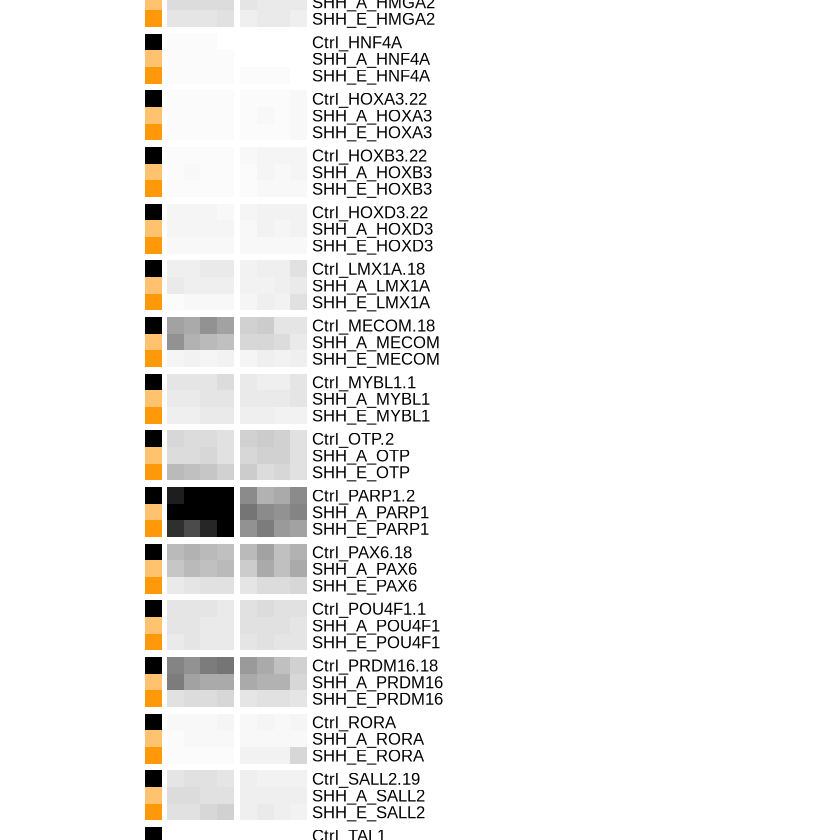

In [498]:
### Fig. 5b ###
all <- all[all$regulon %in% similar$gene_name,]      

variab_selec = c('FOXG1', 'PAX6', 'HEYL', 
                'SOX2',     'RFX2', 'VSX2', 
                 'ZEB1', 'HMGA1', 'POU3F2', 
                 'YBX1')



## breaks rows
split_gene = data.frame(
  cell_type = sapply(strsplit(as.character(all$morphogen_full), "_"), function(x) x[1]),
  genes = all$regulon,
  stringsAsFactors = FALSE
)
split_gene$cell_type<-factor(split_gene$cell_type,
                levels = c('CHIR','SHH','FGF8','RA')) # order of groups of gene



## breaks columns
morphogen_list <- c(
  "NIM_H1", "NIM_H9", "NIM_WIBJ2", "NIM_WTC",
  "NPM_H1", "NPM_H9", "NPM_WIBJ2", "NPM_WTC"
)
first_part_list <- sapply(morphogen_list, function(x) strsplit(x, "_")[[1]][1])
second_part_list <- sapply(morphogen_list, function(x) strsplit(x, "_")[[1]][2])                          
split_col = data.frame(
  medium = first_part_list,
  orig_names = morphogen_list,
    cell = second_part_list,
  stringsAsFactors = FALSE
)
split_col$medium<-factor(split_col$medium,
                levels = c('NIM','NPM'))
rownames(split_col) <- split_col$orig_names


anno_data <- as.data.frame(all$morphogen_full)
rownames(anno_data) <- rownames(all)
colnames(anno_data) <- c('morphogen_full')

anno_col <-as.data.frame(split_col$cell)
rownames(anno_col) <- rownames(split_col)
colnames(anno_col) <- c('cell')         
               

a <- pheatmap(all[, 3:10],
             annotation_row = anno_data,
         annotation_col = anno_col,
          annotation_colors = list(morphogen_full = Morphogen_full,
                                  cell =cols_Cell_Line ),
         
         
          legend_labels = c("Min", "Max"),
    border_color=NA,
        show_rownames = T,
         cluster_rows = F,
         cluster_cols = F,
         color=c(pals::brewer.greys(40)),
              breaks = seq(0,0.5, length.out = 40) ,
        na_col = "antiquewhite",
         cellwidth=10,
                  cellheight=10,
         gaps_row = seq(0, dim(split_gene)[1], by = 3), 
         gaps_col = head(as.numeric(cumsum(table(split_col$medium))), -1), )



save_pheatmap_pdf(a,paste0(path_fig, "raw_similar_heatmap_ctrl_2.pdf"),
                  width = 5, height = 40)

                           

# Plot correlation heatmap

In [514]:
net1 <- read_tsv (paste0(path_data, "consensus_summary_v3.tsv"))
net1$gene_name <- sapply(strsplit(net1$gene, "--"), function(x) gsub("\\(.*\\)", "", x[2]))

keep = c('CHIR:NIM', 'CHIR:NIM:timing_no', 'FGF8:NIM', 'RA:NIM', 'SHH:NIM')

net_comb <- net1[(net1$morph %in% keep), ]
net_comb$morph <- str_replace(net_comb$morph, ":timing_no", "")


net_comb<-net_comb%>% 
  select (morph, gene_name, og_morph, w_H1,	corr_H1,	w_H9,	corr_H9,	w_WIBJ2,	corr_WIBJ2,	w_WTC,	corr_WTC	 )

net_comb_nim<-net_comb[!duplicated(net_comb[c('gene_name','morph')]),]

net_comb_nim[, c("morph_short", "medium")] <- str_split_fixed(net_comb_nim$morph, ":", 2)

Rows: 1471 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): og_morph, gene, link, morph
dbl (9): ...1, w_H1, w_H9, w_WIBJ2, w_WTC, corr_H1, corr_WIBJ2, corr_H9, cor...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [515]:
net1 <- read_tsv (paste0(path_data, "consensus_summary_v3.tsv"))
net1$gene_name <- sapply(strsplit(net1$gene, "--"), function(x) gsub("\\(.*\\)", "", x[2]))

keep = c('CHIR:NPM', 'CHIR:NPM:timing_no', 'FGF8:NPM', 'RA:NPM', 'SHH:NPM')

net_comb <- net1[(net1$morph %in% keep), ]
net_comb$morph <- str_replace(net_comb$morph, ":timing_no", "")


net_comb<-net_comb%>% 
  select (morph, gene_name, og_morph, w_H1,	corr_H1,	w_H9,	corr_H9,	w_WIBJ2,	corr_WIBJ2,	w_WTC,	corr_WTC	 )

net_comb_npm <- net_comb[!duplicated(net_comb[c('gene_name','morph')]),]

net_comb_npm[, c("morph_short", "medium")] <- str_split_fixed(net_comb_npm$morph, ":", 2)

dim(net_comb_npm)
dim(net1)

Rows: 1471 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): og_morph, gene, link, morph
dbl (9): ...1, w_H1, w_H9, w_WIBJ2, w_WTC, corr_H1, corr_WIBJ2, corr_H9, cor...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 100  13

[1] 1471   14

In [516]:
all = full_join(net_comb_nim,net_comb_npm, by = c('morph_short', 'gene_name'))
dim(all[!with(all,is.na(medium.x)| is.na(medium.y)),c('morph_short', 'gene_name', 'medium.x', 'medium.y')])

[1] 59  4

In [517]:
all$gene_morphogen = paste0(all$gene_name, '_', all$morph_short)
all<- all %>% arrange(morph_short, medium.x, medium.y, corr_H1.x,corr_H9.x, corr_H1.y,corr_H9.y)
all <- as.data.frame(all)
rownames(all) <-all$gene_morphogen
all = all[, c('gene_name','morph_short', 'corr_H1.x', 'corr_H9.x',
        'corr_WIBJ2.x', 'corr_WTC.x',  
        'corr_H1.y','corr_H9.y','corr_WIBJ2.y','corr_WTC.y')]

all = t(all)

In [518]:
### add *
net1 <- read_tsv (paste0(path_data, "consensus_summary_v3.tsv"))
net1$gene_name <- sapply(strsplit(net1$gene, "--"), function(x) gsub("\\(.*\\)", "", x[2]))

keep = c('CHIR:NIM', 'CHIR:NIM:timing_no', 'FGF8:NIM', 'RA:NIM', 'SHH:NIM')

net_comb <- net1[(net1$morph %in% keep), ]
net_comb$morph <- str_replace(net_comb$morph, ":timing_no", "")


net_comb<-net_comb%>% 
  select (morph, gene_name, og_morph,	p_value_H1,	p_value_H9, p_value_WIBJ2,	p_value_WTC	 )

net_comb_nim<-net_comb[!duplicated(net_comb[c('gene_name','morph')]),]

net_comb_nim[, c("morph_short", "medium")] <- str_split_fixed(net_comb_nim$morph, ":", 2)

net1 <- read_tsv (paste0(path_data, "consensus_summary_v3.tsv"))
net1$gene_name <- sapply(strsplit(net1$gene, "--"), function(x) gsub("\\(.*\\)", "", x[2]))

keep = c('CHIR:NPM', 'CHIR:NPM:timing_no', 'FGF8:NPM', 'RA:NPM', 'SHH:NPM')

net_comb <- net1[(net1$morph %in% keep), ]
net_comb$morph <- str_replace(net_comb$morph, ":timing_no", "")


net_comb<-net_comb%>% 
  select (morph, gene_name, og_morph, p_value_H1,	p_value_H9, p_value_WIBJ2,	p_value_WTC	  )

net_comb_npm <- net_comb[!duplicated(net_comb[c('gene_name','morph')]),]

net_comb_npm[, c("morph_short", "medium")] <- str_split_fixed(net_comb_npm$morph, ":", 2)
                         

Rows: 1471 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (4): og_morph, gene, link, morph
dbl (13): ...1, w_H1, w_H9, w_WIBJ2, w_WTC, corr_H1, p_value_H1, corr_WIBJ2,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1471 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (4): og_morph, gene, link, morph
dbl (13): ...1, w_H1, w_H9, w_WIBJ2, w_WTC, corr_H1, p_value_H1, corr_WIBJ2,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [519]:
alltext = full_join(net_comb_nim,net_comb_npm, by = c('morph_short', 'gene_name'))
dim(alltext[!with(alltext,is.na(medium.x)| is.na(medium.y)),c('morph_short', 'gene_name', 'medium.x', 'medium.y')])

alltext$gene_morphogen = paste0(alltext$gene_name, '_', alltext$morph_short)
alltext<- alltext %>% arrange(morph_short, medium.x, medium.y,  p_value_H1.x, p_value_H9.x,
                               p_value_H1.y, p_value_H9.y)
alltext <- as.data.frame(alltext)
rownames(alltext) <-alltext$gene_morphogen
alltext = alltext[, c('gene_name','morph_short', 'p_value_H1.x', 'p_value_H9.x',
        'p_value_WIBJ2.x', 'p_value_WTC.x',  
        'p_value_H1.y','p_value_H9.y','p_value_WIBJ2.y','p_value_WTC.y')]

alltext = t(alltext)


[1] 59  4

In [520]:
df_text <-alltext[3:10, ] %>% as_tibble() %>% mutate(across(everything(), as.numeric))
df_text <- as.data.frame(df_text)
rownames(df_text) <- rownames(alltext)[3:10]
df_text[df_text <= 0.01] <- '*'

df_text[df_text > 0.01] <- ''
df_text[is.na(df_text) ]<- ''  

png 
  2

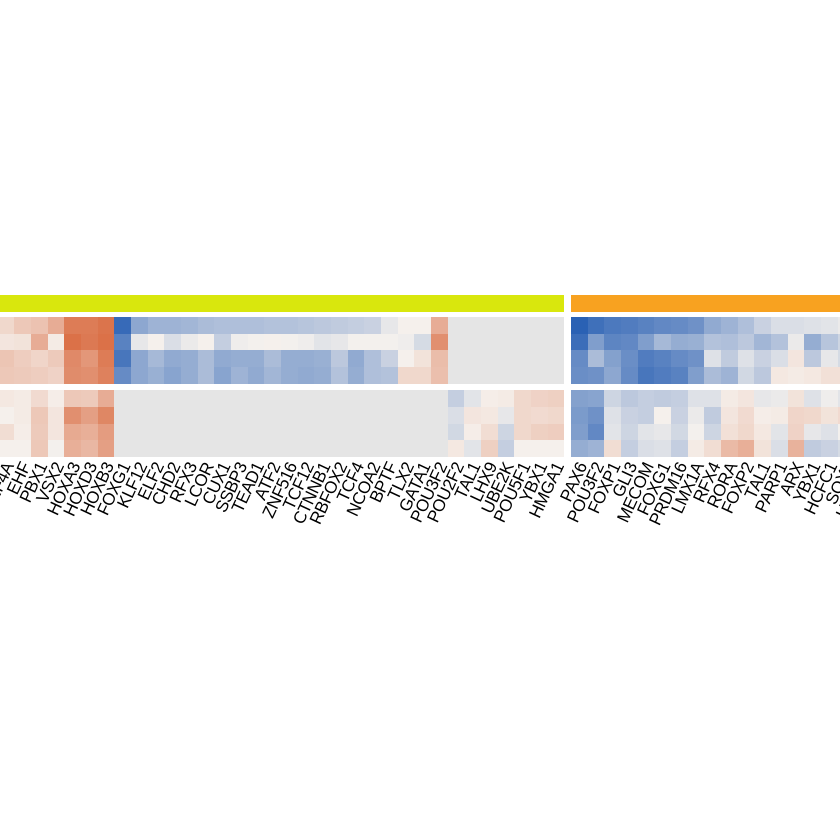

In [521]:
draw_colnames_45 <- function (coln, gaps, ...) {
   coord <- pheatmap:::find_coordinates(length(coln), gaps)
   x     <- coord$coord - 0.5 * coord$size
  res   <- grid::textGrob(
   coln, x = x, y = unit(1, "npc") - unit(3,"bigpts"),
      vjust = 0.75, hjust = 1, rot = 65, gp = grid::gpar(...)
    )
    return(res)
}
assignInNamespace(
 x = "draw_colnames",
 value = "draw_colnames_45",
 ns = asNamespace("pheatmap")
)



anno_col = as.data.frame(all['morph_short',])
colnames(anno_col) <- c('morph_short')
#anno_data = data.frame()
anno_data <- as.data.frame(c('H1', 'H9', 'WIBJ2', 'WTC', 'H1', 'H9', 'WIBJ2', 'WTC'))
rownames(anno_data) <- rownames(all)[3:10]
colnames(anno_data) <- c('cell')


df_numeric <- all[3:10, ] %>% as_tibble() %>% mutate(across(everything(), as.numeric))
df_numeric <- as.data.frame(df_numeric)
rownames(df_numeric) <- rownames(all)[3:10]



# split col
split_col= data.frame(
  morph = all['morph_short',],
  genes = colnames(df_numeric),
  stringsAsFactors = FALSE
)
# split row
split_row = data.frame(
  medium = c('NIM', 'NIM', 'NIM', 'NIM', 'NPM', 'NPM','NPM','NPM'),
 
  stringsAsFactors = FALSE
)

#rownames(split_col) <- split_col$orig_names


blue_red <- colorRampPalette(c("#225bb2", "#f6f2ee", "#da6c42"))(100)

midpoint <- 0
range_values <- range(df_numeric)
breaks <- c(seq(-0.5, 0, length.out = 50), seq(0.01, 0.85, length.out = 50))


## Add top cluster

In [542]:
top_cl = read_tsv(paste0(path_data, 'top_cluster.tsv'))
colnames(top_cl) <- c('regulon', 'Cell_type')
top_cl$gene <- sapply(strsplit(top_cl$regulon, "--"), function(x) gsub("\\(.*\\)", "", x[2]))
head(top_cl)

New names:
• `` -> `...1`
Rows: 136 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): ...1, 0

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


regulon,Cell_type,gene
<chr>,<chr>,<chr>
combined--EP300(+),CNS Neurons,EP300
combined--SOX11(+),CNS Neurons,SOX11
combined--BPTF(+),Neural Crest,BPTF
combined--CHD2(+),PNS Neurons,CHD2
combined--TEAD1(+),Neural Crest,TEAD1
combined--YBX1(+),Retinal Progenitors,YBX1


In [556]:
anno_col = as.data.frame(all['morph_short',])
colnames(anno_col) <- c('morph_short')

anno_col$gene <- sub("_.*", "", rownames(anno_col)) 
anno_col = left_join(anno_col, top_cl[,c('Cell_type', 'gene')], by = 'gene')
rownames(anno_col) <- colnames(all)
anno_col$gene <- NULL
head(anno_col)

,morph_short,Cell_type
,<chr>,<chr>
SALL2_CHIR,CHIR,Hypothalamic Progenitors
HOXA3_CHIR,CHIR,Spinal Cord Progenitors
HOXC6_CHIR,CHIR,Spinal Cord Progenitors
HMGA1_CHIR,CHIR,Retinal Progenitors
HOXB3_CHIR,CHIR,Spinal Cord Progenitors
HOXB9_CHIR,CHIR,Spinal Cord Progenitors


png 
  2

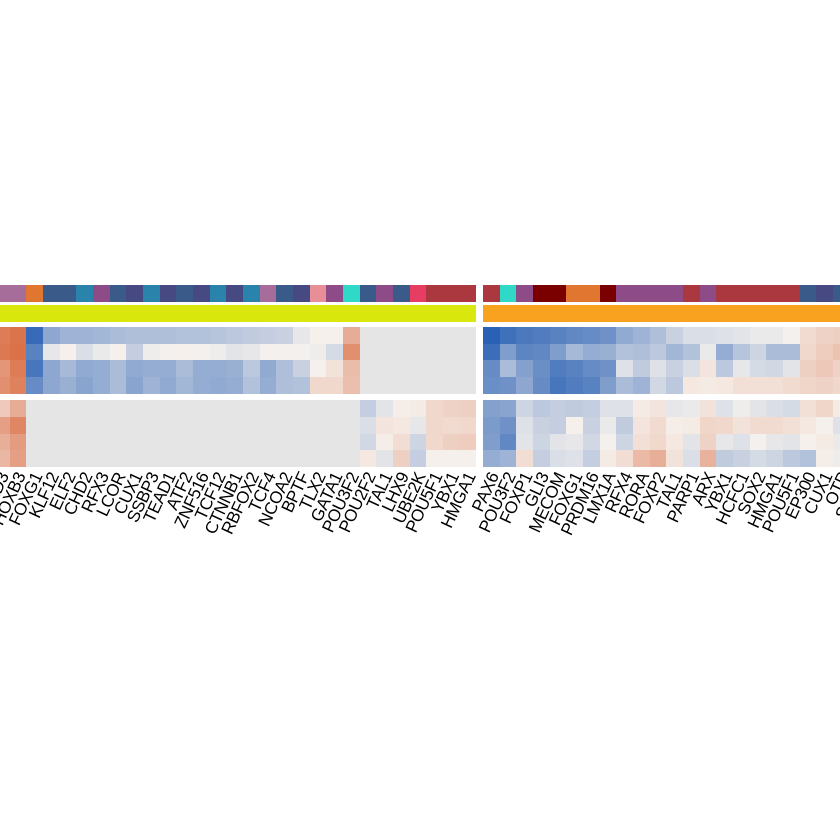

In [557]:
### Fig. 5c ###

cols_fullname = c(
    "Telencephalic Progenitors" = "#e0762f",
    "Spinal Cord Progenitors" = "#a66d9b",
    "Hindbrain Progenitors" = "#e78e97",
    "Neuroectoderm/Neuroepithelium" = "#f4c617",
    "Hypothalamic Progenitors" = "#e83d63",
    "CNS Neurons" = "#3a5a89",
    "Cortical Hem/Diencephalon" = "#7A0000",
    "PNS Neurons" = "#2983aa",
    "Floor Plate" = "#8d4c88",
    "Midbrain Progenitors" = "#30d8c8",
    "Retinal Progenitors" = "#ac383f",
    "Mesenchyme" = "#92c051",
    "Neural Crest" = "#474a82",
    "Extraembryonic Tissue" = "#A5BC7B",
    "Endoderm/mesoderm-derived tissues" = "#67BD1B",
    "Non-neurectodermal tissues" = "#92c051",
    "Hindbrain Progenitors" = "#f3c2c7"
)





a <- pheatmap(df_numeric,
             annotation_row = anno_data,
             annotation_col = anno_col,
              annotation_colors = list(morph_short = c("SHH"= "#F8A220", 
                                                     "RA"= "#D9E70D", 
                                                     "FGF8"= "#883EB6", 
                                                     "CHIR"="#098684"),
                                                      cell =cols_Cell_Line,
                                                      'Cell_type' = cols_fullname),

              labels_col = sub("_.*", "", colnames(df_numeric)) ,
              labels_row = c('H1', 'H9', 'WIBJ2', 'WTC' ,'H1', 'H9', 'WIBJ2', 'WTC'),
         
         
         
            border_color=NA,
            show_rownames = T,
            cluster_rows = F,
            cluster_cols = F,
            color=blue_red,
            breaks = breaks,
            na_col = "grey90",
            cellwidth=10,
            cellheight=10,
             gaps_row = head(as.numeric(cumsum(table(split_row$medium))), -1), 
             gaps_col = head(as.numeric(cumsum(table(split_col$morph))), -1), )



save_pheatmap_pdf(a, paste0(path_fig, "correl_heatmap_with_top.pdf"),
                  width = 25, height = 5)